In [2]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
from matchms.importing import load_from_json
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot as plt 

ROOT = os.path.dirname(os.getcwd())
sys.path.insert(0, ROOT)
sys.path.insert(0, os.path.join(ROOT, "ms2deepscore"))
path_data_gnps = 'C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA\\matchms\\data\\'
path_data = 'C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA\\ms2deepscore\\data\\'

## Define functions to make spectrum vector for ML model

In [3]:
from utils import create_peak_dict
from spectrum_binning_fixed import create_peak_list_fixed, unique_peaks_fixed, set_d_bins_fixed

## Load spectra

In [5]:
outfile = os.path.join(path_data_gnps,'gnps_positive_ionmode_annotated_w_fps_processed.pickle')
with open(outfile, 'rb') as file:
    spectrums_annotated = pickle.load(file)

In [7]:
metadata_file = os.path.join(path_data, "metadata_AllInchikeys.csv")
metadata = pd.read_csv(metadata_file)
metadata.head()

,Unnamed: 0,inchikey,inchi,ID
0,0,MYHSVHWQEVDFQT-RLIDIOMENA-N,InChI=1/C11H19NO10S2/c1-2-5(14)3-7(12-22-24(18...,75971
1,1,BKAWJIRCKVUVED-UHFFFAOYSA-N,"InChI=1S/C6H9NOS/c1-5-6(2-3-8)9-4-7-5/h4,8H,2-...",17330
2,2,CXVGEDCSTKKODG-UHFFFAOYSA-N,InChI=1S/C14H12O6S/c1-20-12-8-11(15)10(7-13(12...,422
3,3,JAMSDVDUWQNQFZ-QNQJCTKXSA-N,InChI=1S/C52H102NO8P/c1-6-8-10-12-14-16-18-20-...,38937
4,4,ODHCTXKNWHHXJC-GSVOUGTGSA-N,"InChI=1S/C5H7NO3/c7-4-2-1-3(6-4)5(8)9/h3H,1-2H...",46378


### Load reference scores (Tanimoto)

In [8]:
filename = os.path.join(path_data,'similarities_AllInchikeys_daylight2048_jaccard.npy')
scores_mol_similarity = np.load(filename)

In [9]:
scores_mol_similarity.shape

(14459, 14459)

In [10]:
ID = 100
np.where((scores_mol_similarity[ID,:] > 0.7) & (scores_mol_similarity[ID,:] < 0.99))[0]

array([ 3339,  5594, 10540], dtype=int64)

In [11]:
metadata.loc[ID]["inchi"], metadata.loc[3339]["inchi"]

('InChI=1S/C20H39NO4S/c1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-20(22)21-18-19-26(23,24)25/h9-10H,2-8,11-19H2,1H3,(H,21,22)(H,23,24,25)/b10-9-',
 'InChI=1S/C21H41NO4S/c1-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-21(23)22(2)19-20-27(24,25)26/h10-11H,3-9,12-20H2,1-2H3,(H,24,25,26)/b11-10-')

## Build data pipeline for training on AllInchikeys dataset
### Split dataset into train/val/test

In [13]:
split_ratio = (0.9, 0.05, 0.05)

np.random.seed(111)

N_label = metadata.shape[0]
idx = np.arange(0, N_label)
N_train = int(split_ratio[0] * N_label)
N_val = int(split_ratio[1] * N_label)
N_test = N_label - N_train - N_val
print("Split dataset into train/val/test fractions:", N_train, N_val, N_test)

# Select training, validation, and test IDs:
trainIDs = np.random.choice(idx, N_train, replace=False)
valIDs = np.random.choice(list(set(idx) - set(trainIDs)), N_val, replace=False)
testIDs = list(set(idx) - set(trainIDs) - set(valIDs))

Split dataset into train/val/test fractions: 13013 722 724


In [16]:
scores_mol_similarity[:5,:5]

array([[1.        , 0.09930716, 0.23619371, 0.20579111, 0.09101251],
       [0.09930716, 1.        , 0.09296782, 0.08462867, 0.06852792],
       [0.23619371, 0.09296782, 1.        , 0.14127144, 0.1026253 ],
       [0.20579111, 0.08462867, 0.14127144, 1.        , 0.13392857],
       [0.09101251, 0.06852792, 0.1026253 , 0.13392857, 1.        ]])

In [15]:
maxima = np.max(scores_mol_similarity, axis=0)
false_scores = np.where(maxima<0.1)[0]
false_scores

array([], dtype=int64)

In [17]:
trainIDs[:10]

array([11925,  2413, 13459, 12783, 13292,  1785, 13828,   637,  7179,
       10400])

## Convert spectra into binned spectra and peak dicts

In [ ]:
from spectrum_binning_fixed import create_peak_list_fixed, set_d_bins_fixed, unique_peaks_fixed

In [31]:
# Set binning --> Linear
number_of_bins = 10000
mz_max = 1000.0
mz_min = 10.0
min_bin_size = 0.05
weight_power = 0.5

d_bins = set_d_bins_linear(number_of_bins, min_bin_size=min_bin_size, mz_min=mz_min, mz_max=mz_max)
print(d_bins)

9.800980098009801e-06


In [35]:
bin_number_array_linear(np.array([10., 1000.]), min_bin_size, d_bins, mz_min)

array([   0, 9999])

In [67]:
# Set binning --> FIXED
number_of_bins = 10000
mz_max = 1000.0
mz_min = 10.0
weight_power = 0.5

d_bins = set_d_bins_fixed(number_of_bins, mz_min=mz_min, mz_max=mz_max)
print("d_bins:", d_bins)

class_values, unique_peaks = unique_peaks_fixed(spectrums_annotated, d_bins, mz_min)
vector_dim = len(unique_peaks)
print("Vector dimension:", vector_dim)

d_bins: 0.099
Vector dimension: 9998


In [68]:
spectrums_binned = create_peak_list_fixed(spectrums_annotated, d_bins, mz_min=mz_min, weight_power=weight_power)
spectrums_binned_dicts = [create_peak_dict(spec) for spec in spectrums_binned]

In [35]:
count_bin_filling = []
for spec in spectrums_binned[:1000]:
    count_bin_filling += [x[0] for x in spec]

(array([ 24919.,  59485.,  67680.,  65502.,  73261., 103366.,  91688.,
         74056.,  63107.,  57388.,  52138.,  47319.,  44959.,  41898.,
         40832.,  37023.,  27006.,  23809.,  21087.,  17134.,  14686.,
         11302.,   9818.,   9078.,   8447.]),
 array([ 100.  ,  495.88,  891.76, 1287.64, 1683.52, 2079.4 , 2475.28,
        2871.16, 3267.04, 3662.92, 4058.8 , 4454.68, 4850.56, 5246.44,
        5642.32, 6038.2 , 6434.08, 6829.96, 7225.84, 7621.72, 8017.6 ,
        8413.48, 8809.36, 9205.24, 9601.12, 9997.  ]),
 <BarContainer object of 25 artists>)

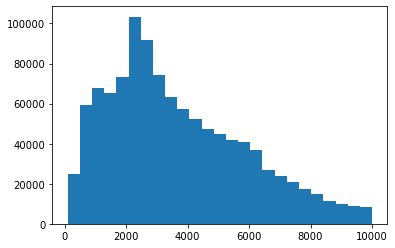

In [37]:
plt.hist(count_bin_filling, 25)

In [ ]:
from spectrum_binning_linear import create_peak_list_linear, set_d_bins_linear, unique_peaks_linear

In [56]:
# Set binning --> LINEAR increasing
number_of_bins = 10000
mz_max = 1000.0
mz_min = 10.0
min_bin_size = 0.025
weight_power = 0.5

d_bins = set_d_bins_linear(number_of_bins, min_bin_size=min_bin_size, mz_min=mz_min, mz_max=mz_max)
print("d_bins:", d_bins)

d_bins: 1.4801480148014802e-05


In [57]:
bins = min_bin_size + np.arange(0, number_of_bins) * d_bins
bins

array([0.025    , 0.0250148, 0.0250296, ..., 0.1729704, 0.1729852,
       0.173    ])

In [58]:
class_values, unique_peaks = unique_peaks_linear(spectrums_annotated, min_bin_size, d_bins, mz_min)
vector_dim = len(unique_peaks)
print("Vector dimension:", vector_dim)

Vector dimension: 9862


In [59]:
mz = np.array([10, 10.051, 10.11, 10.2, 15, 100, 1000])
bin_number_linear(mz, min_bin_size, d_bins).astype(int), bin_number_array_linear(mz, min_bin_size, d_bins)

(array([   0,    2,    4,    7,  189, 2185, 9999]),
 array([   0,    2,    4,    7,  189, 2185, 9999]))

In [60]:
spectrums_binned = create_peak_list_linear(spectrums_annotated, class_values,
                                           min_bin_size, d_bins, mz_min=mz_min, weight_power=weight_power)
spectrums_binned_dicts = [create_peak_dict(spec) for spec in spectrums_binned]

In [61]:
count_bin_filling = []
for spec in spectrums_binned[:1000]:
    count_bin_filling += [x[0] for x in spec]

(array([  146.,  7534., 28694., 29850., 33994., 41402., 43585., 47264.,
        58813., 87176., 83230., 75040., 65561., 62794., 58928., 55804.,
        54644., 53029., 51707., 37894., 32903., 26545., 19919., 16036.,
        14496.]),
 array([ 260.  ,  644.04, 1028.08, 1412.12, 1796.16, 2180.2 , 2564.24,
        2948.28, 3332.32, 3716.36, 4100.4 , 4484.44, 4868.48, 5252.52,
        5636.56, 6020.6 , 6404.64, 6788.68, 7172.72, 7556.76, 7940.8 ,
        8324.84, 8708.88, 9092.92, 9476.96, 9861.  ]),
 <BarContainer object of 25 artists>)

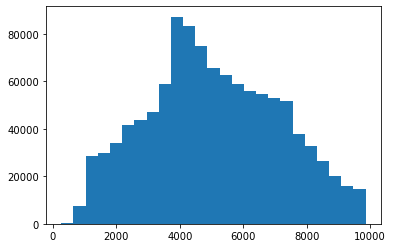

In [62]:
plt.hist(count_bin_filling, 25)

## Data generator for more balanced training data

In [63]:
from data_generators import DataGenerator_all_inchikeys

In [64]:
inchikeys_list = []
for s in spectrums_annotated:
    inchikeys_list.append(s.get("inchikey"))

inchikeys_array = np.array(inchikeys_list)

In [71]:
same_prob_bins = list(zip(0.1*np.arange(10), (0.1 + 0.1*np.arange(10))))
#same_prob_bins = [(0., 0.1), (0.1, 0.2), (0.2, 0.3), (0.3, 0.4), (0.4, 0.5),
#                 (0.5, 0.58), (0.58, 0.66), (0.66, 0.74), (0.74, 0.82), (0.82, 0.9),
#                 (0.9, 0.98), (0.98, 1.0)]

train_generator = DataGenerator_all_inchikeys(trainIDs, batch_size=16, num_turns=2, dim=(vector_dim), shuffle=True,
                                              ignore_equal_pairs=True,
                                              score_array=scores_mol_similarity, 
                                              inchikey_mapping=metadata, inchikeys_array = inchikeys_array,
                                              same_prob_bins=same_prob_bins,
                                              augment_peak_removal={"max_removal": 0.4, "max_intensity": 0.2**0.5},
                                              augment_intensity=0.4)

val_generator = DataGenerator_all_inchikeys(valIDs, batch_size=16, num_turns=5, dim=(vector_dim), shuffle=True,
                                            ignore_equal_pairs=True,
                                            score_array=scores_mol_similarity, 
                                            inchikey_mapping=metadata, inchikeys_array = inchikeys_array,
                                            same_prob_bins=same_prob_bins,
                                            augment_peak_removal={"max_removal": 0.01, "max_intensity": 0.01**0.5},
                                            augment_intensity=0.1)

In [100]:
same_prob_bins

[(0.0, 0.1),
 (0.1, 0.2),
 (0.2, 0.30000000000000004),
 (0.30000000000000004, 0.4),
 (0.4, 0.5),
 (0.5, 0.6),
 (0.6000000000000001, 0.7000000000000001),
 (0.7000000000000001, 0.8),
 (0.8, 0.9),
 (0.9, 1.0)]

## Deep learning network
- score based on cosine similarity layer
- large network
- L1 regularization + dropout + data augmentation to enforce better generalization
- relu activations for creating embeddings (tanh activation wasn't very good!)

In [68]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Input, Flatten, Subtract, Lambda, Concatenate, \
    GaussianNoise, Dot, Dropout
from tensorflow.keras.models import Model

In [72]:
dense_dims = [600, 600, 500, 400]
dropout_rate = 0.2
print("Vector dimension:", vector_dim)

# Encoder network
input_data  = Input(shape = (1, vector_dim), name="encoder_input")
encoding = Dense(dense_dims[0], activation = 'relu', kernel_regularizer=tf.keras.regularizers.l1(1e-6),
                 name="dense_101")(input_data)

encoding = Dense(dense_dims[1], activation = 'relu', name="dense_102")(encoding)
encoding = Dropout(dropout_rate)(encoding)
encoding = Dense(dense_dims[2], activation = 'relu', name="dense_103")(encoding)
encoding = Dropout(dropout_rate)(encoding)
encoding = Dense(dense_dims[3], activation = 'relu', name="dense_104")(encoding)

encoder = Model(input_data, encoding)

# Scoring network
spectrum1 = Input(shape = (1, vector_dim), name="scoring_input1")
spectrum2 = Input(shape = (1, vector_dim), name="scoring_input2")

embedding1 = encoder(spectrum1)
embedding2 = encoder(spectrum2)

cosine_similarity = Dot(axes=(2, 2), normalize=True, name="cosine_similarity")([embedding1, embedding2])

scoring_network = Model(inputs=[spectrum1, spectrum2], outputs = [cosine_similarity])

scoring_network.summary()
encoder.summary()

Vector dimension: 9862
Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
scoring_input1 (InputLayer)     [(None, 1, 9862)]    0                                            
__________________________________________________________________________________________________
scoring_input2 (InputLayer)     [(None, 1, 9862)]    0                                            
__________________________________________________________________________________________________
functional_5 (Functional)       (None, 1, 400)       6779300     scoring_input1[0][0]             
                                                                 scoring_input2[0][0]             
__________________________________________________________________________________________________
cosine_similarity (Dot)         (None, 1, 1)         0          

In [73]:
epochs = 150
learning_rate = 0.001
metrics = ["mae"]

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

# Parameters
patience_scoring_net = 10
scoring_network_output_file = "scoring_network_201109_AllInchikey_cosine_large.hdf5"

scoring_network.compile(
    loss='mse',
    optimizer=Adam(learning_rate=learning_rate),
    metrics=metrics)

checkpointer = ModelCheckpoint(
    filepath = scoring_network_output_file,
    monitor='val_loss', mode="min",
    verbose=1,
    save_best_only=True
    )

earlystopper_scoring_net = EarlyStopping(
    monitor='val_loss', mode="min",
    patience=patience_scoring_net,
    verbose=1
    )

history = scoring_network.fit_generator(
    generator=train_generator,
    validation_data=val_generator,
    epochs = epochs,
    callbacks = [
        earlystopper_scoring_net,
        checkpointer,
        ]
    )

Epoch 1/150
1626/1626 [==============================] - ETA: 0s - loss: 0.1160 - mae: 0.2048  - ETA: 1:33 - l - ETA: 1:28 -  - ETA: 1:23 - loss: 0.1 - ETA
Epoch 00001: val_loss improved from inf to 0.11224, saving model to scoring_network_201109_AllInchikey_cosine_large.hdf5
1626/1626 [==============================] - 332s 204ms/step - loss: 0.1160 - mae: 0.2048 - val_loss: 0.1122 - val_mae: 0.1817
Epoch 2/150
1626/1626 [==============================] - ETA: 0s - loss: 0.1062 - mae: 0.1888- 
Epoch 00002: val_loss improved from 0.11224 to 0.10775, saving model to scoring_network_201109_AllInchikey_cosine_large.hdf5
1626/1626 [==============================] - 323s 199ms/step - loss: 0.1062 - mae: 0.1888 - val_loss: 0.1077 - val_mae: 0.1809
Epoch 3/150
1626/1626 [==============================] - ETA: 0s - loss: 0.0996 - mae: 0.1794
Epoch 00003: val_loss improved from 0.10775 to 0.10577, saving model to scoring_network_201109_AllInchikey_cosine_large.hdf5
1626/1626 [==================

Epoch 24/150
1626/1626 [==============================] - ETA: 0s - loss: 0.0649 - mae: 0.1416
Epoch 00024: val_loss did not improve from 0.06702
1626/1626 [==============================] - 290s 178ms/step - loss: 0.0649 - mae: 0.1416 - val_loss: 0.0688 - val_mae: 0.1447
Epoch 25/150
1626/1626 [==============================] - ETA: 0s - loss: 0.0637 - mae: 0.1399- ETA: 0s - loss: 0.0637 - mae: 0.
Epoch 00025: val_loss did not improve from 0.06702
1626/1626 [==============================] - 296s 182ms/step - loss: 0.0637 - mae: 0.1399 - val_loss: 0.0688 - val_mae: 0.1419
Epoch 26/150
1626/1626 [==============================] - ETA: 0s - loss: 0.0633 - mae: 0.1402
Epoch 00026: val_loss did not improve from 0.06702
1626/1626 [==============================] - 287s 176ms/step - loss: 0.0633 - mae: 0.1402 - val_loss: 0.0677 - val_mae: 0.1428
Epoch 27/150
1626/1626 [==============================] - ETA: 0s - loss: 0.0627 - mae: 0.1400- ETA: 7s - loss: 0.0628 - mae:  - ETA: 6s - loss - E

In [75]:
history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

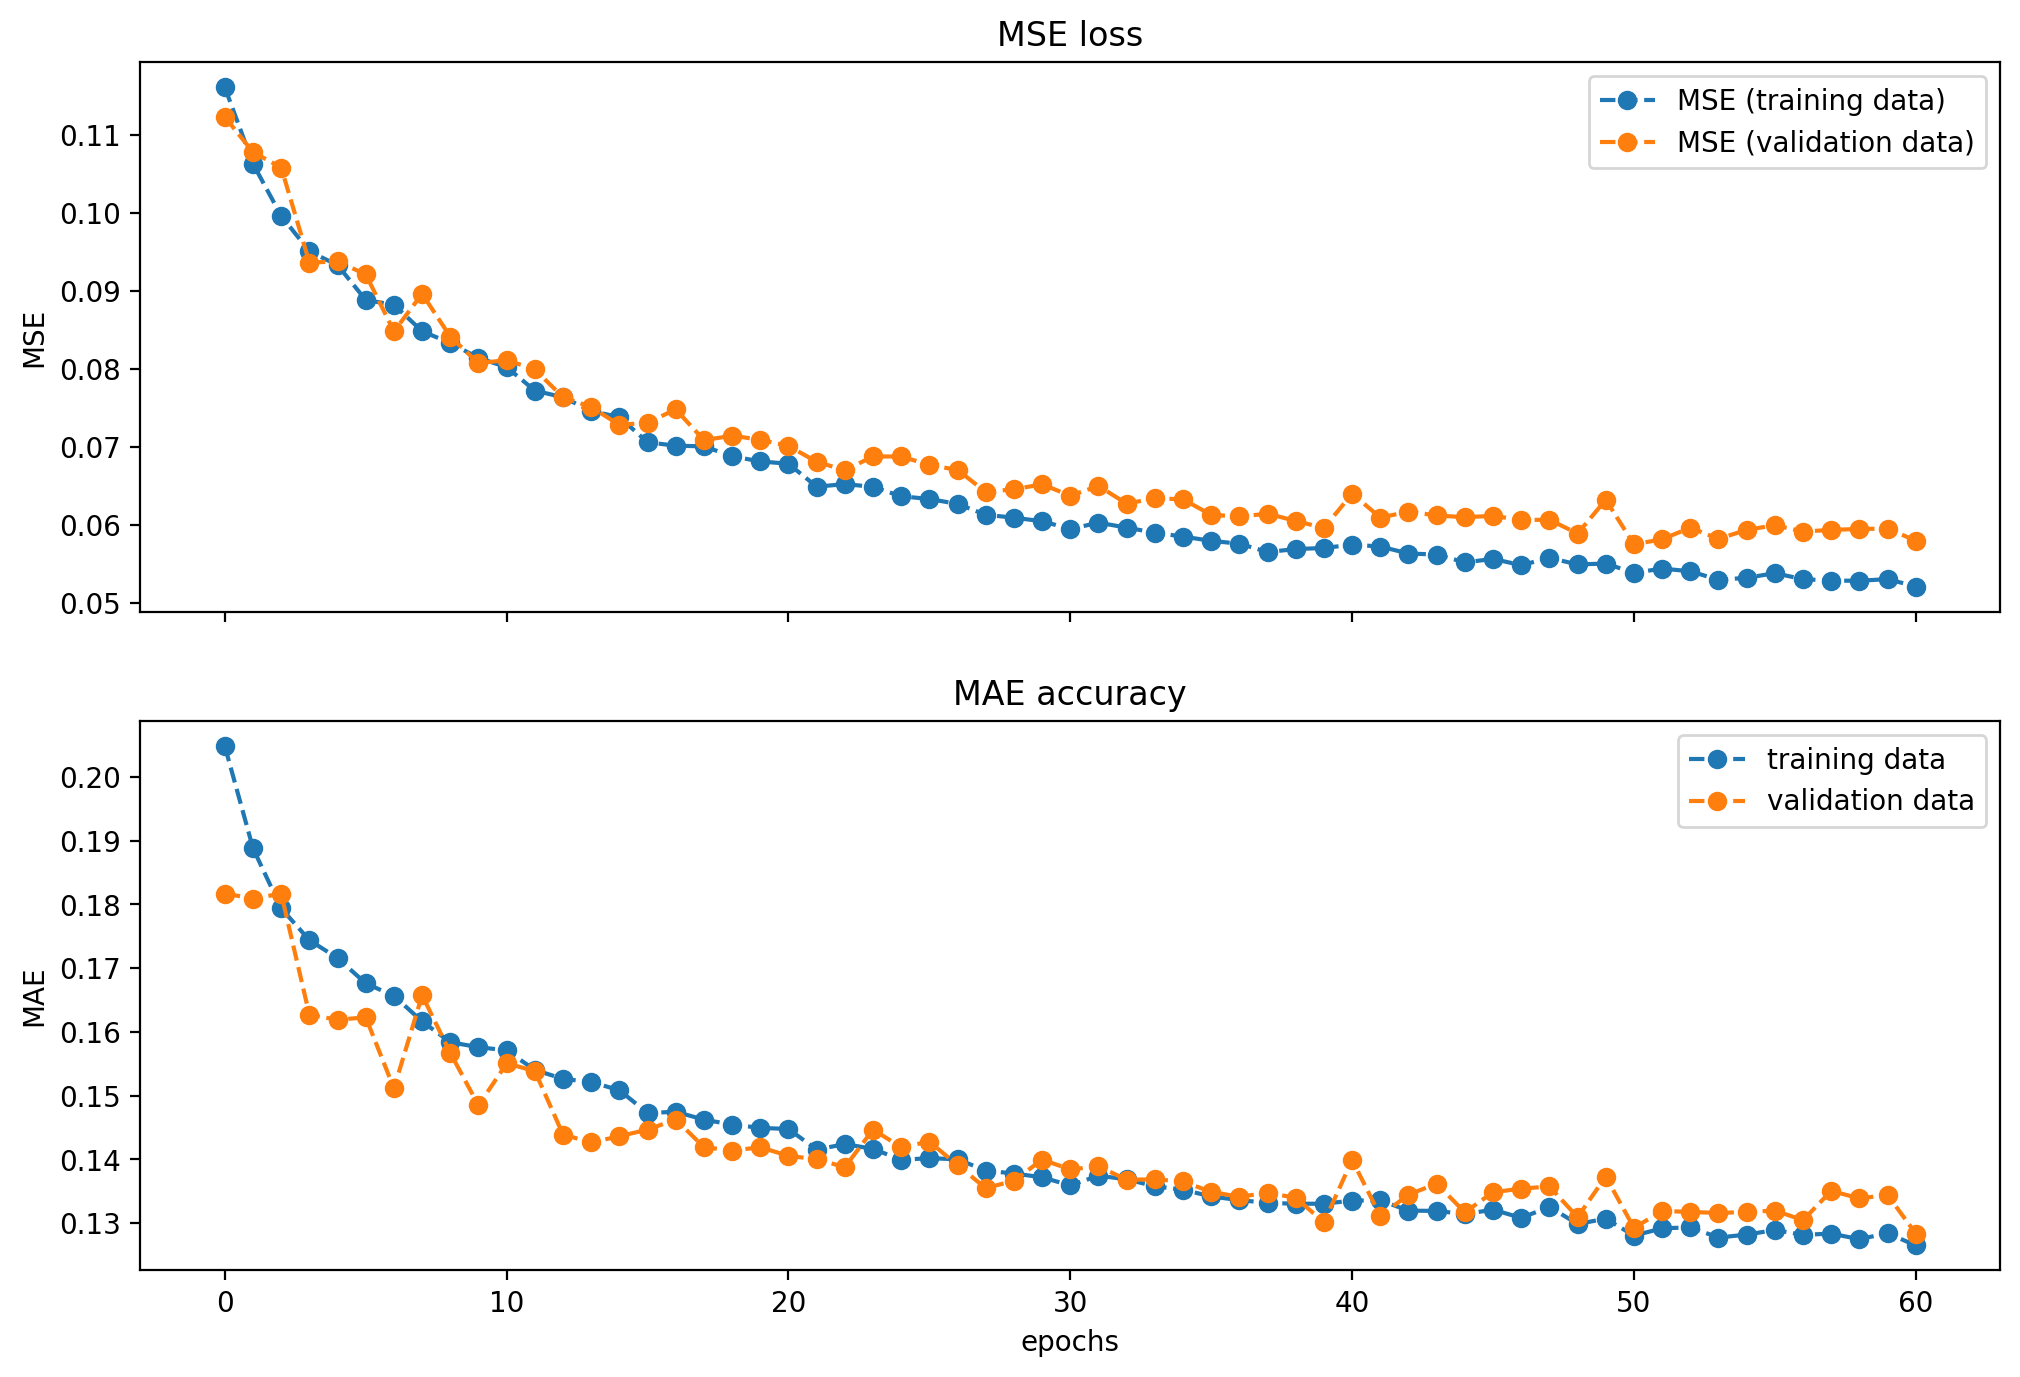

In [76]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,8), dpi=200)

ax1.plot(history.history['loss'], "o--", label='MSE (training data)')
ax1.plot(history.history['val_loss'], "o--", label='MSE (validation data)')
ax1.set_title('MSE loss')
ax1.set_ylabel("MSE")
ax1.legend()

ax2.plot(history.history['mae'], "o--", label='training data')
ax2.plot(history.history['val_mae'], "o--", label='validation data')
ax2.set_title('MAE accuracy')
ax2.set_ylabel("MAE")
ax2.set_xlabel("epochs")
ax2.legend()

In [77]:
filename = "scoring_network_201109_AllInchikey_cosine_large.hdf5"
scoring_network = tf.keras.models.load_model(filename)

In [78]:
embedding_dim = 400
dense_dims = [600, 600, 500, 400]
dropout_rate = 0.2
print("Vector dimension:", vector_dim)

# Encoder network
input_data  = Input(shape = (1, vector_dim), name="encoder_input")
encoding = Dense(dense_dims[0], activation = 'relu', #kernel_regularizer=tf.keras.regularizers.l1(1e-6),
                 name="dense_101")(input_data)

encoding = Dense(dense_dims[1], activation = 'relu', name="dense_102")(encoding)
encoding = Dense(dense_dims[2], activation = 'relu', name="dense_103")(encoding)
encoding = Dense(dense_dims[3], activation = 'relu', name="dense_104")(encoding)

encoder = Model(input_data, encoding)

for i, num in enumerate([0, 1, 2, 4, 6]):   
    encoder.layers[i].set_weights(scoring_network.layers[2].layers[num].get_weights())
encoder.summary()

Vector dimension: 9862
Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 1, 9862)]         0         
_________________________________________________________________
dense_101 (Dense)            (None, 1, 600)            5917800   
_________________________________________________________________
dense_102 (Dense)            (None, 1, 600)            360600    
_________________________________________________________________
dense_103 (Dense)            (None, 1, 500)            300500    
_________________________________________________________________
dense_104 (Dense)            (None, 1, 400)            200400    
Total params: 6,779,300
Trainable params: 6,779,300
Non-trainable params: 0
_________________________________________________________________


In [79]:
#def create_similarity_matrix(IDs, embedding_dim, encoder, inchikey_mapping, inchikey_list):
    
def get_embedding_array(IDs, embedding_dim, encoder, inchikey_mapping, inchikey_list):
    embeddings = np.zeros((len(IDs), embedding_dim))
    for i, ID in enumerate(IDs):
        X = np.zeros((1, encoder.input_shape[2]))
        inchikey = inchikey_mapping.loc[ID]["inchikey"]
        ID1_all = np.where(inchikey_list == inchikey)[0][0]
        idx = np.array([x for x in spectrums_binned_dicts[ID1_all].keys()])
        X[0, idx] = np.array([x for x in spectrums_binned_dicts[ID1_all].values()])
        embeddings[i, :] = encoder.predict(X)

    return embeddings

embeddings = get_embedding_array(testIDs, embedding_dim, encoder, metadata, inchikeys_array)

In [80]:
embeddings[4,:][:100]

array([  0.        , 170.11152649,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
       117.15350342,   0.        ,  69.58101654,   0.        ,
         0.        , 128.57925415,  91.72380066,   0.        ,
         0.        ,   0.        , 124.30633545, 274.03686523,
         0.        , 366.69342041, 112.50513458,   0.        ,
         0.        ,   0.        ,   0.        ,  46.54550934,
       150.80014038,   0.        ,   0.        ,  18.34052277,
       249.26243591, 114.64514923, 271.50238037,   0.        ,
         0.        ,   0.        ,   0.        ,  18.15123367,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        , 129.43632507,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        , 293.2986145 ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,  53.92356873,   0.        ,   0.        ,
         0.        ,   0.        , 153.06523132, 457.53

In [84]:
np.max(embeddings[4,:])

591.112060546875

In [81]:
from matchms.similarity.vector_similarity_functions import cosine_similarity_matrix, cosine_similarity

MS2DS_scores = cosine_similarity_matrix(embeddings, embeddings)

In [87]:
cosine_similarity(embeddings[1,:]/100, embeddings[10,:]/100)

0.482130076465808

In [82]:
scores_ref = scores_mol_similarity[np.ix_(testIDs[:], testIDs[:])].copy()

In [83]:
n_bins = 10
d_bin = 1/n_bins
hist_bins = np.linspace(0, 1, 100) 
hist_bins = np.concatenate((hist_bins, np.array([2.0])))

histograms = []
for i in range(n_bins):
    idx = np.where((scores_ref > i*d_bin) & (scores_ref <= (i + 1) * d_bin))
    a, b = np.histogram(MS2DS_scores[idx], bins=hist_bins)
    histograms.append((a, b))

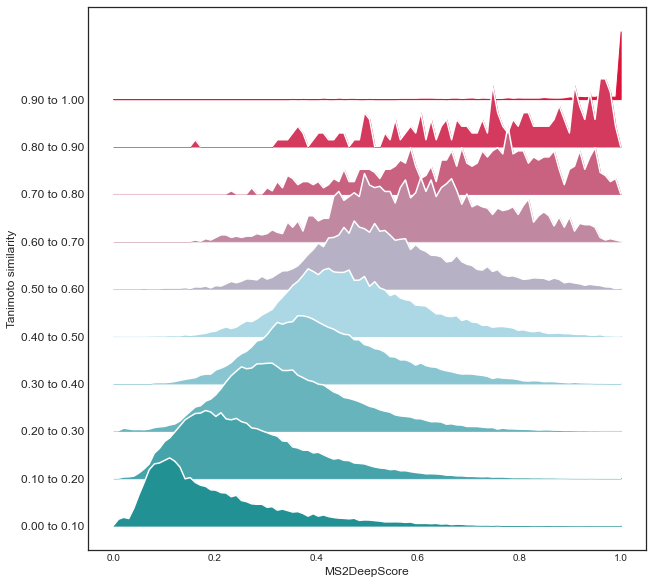

In [88]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def plot_histograms(histograms, xlabel="MS2DeepScore", ylabel="Tanimoto similarity"):
    colors = ["crimson", "lightblue", "teal"]
    cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)


    plt.figure(figsize=(10,10))
    #fig, axes = plt.subplots(1, 1, sharex=True)
    plt.style.use('seaborn-white')

    shift = 0.7
    alpha = 1.0 #0.5

    tanimoto_bins = []
    for i in range(n_bins):
        tanimoto_bins.append((i*d_bin, (i+1)*d_bin))

    for i in range(0, len(histograms)):
        data = histograms[len(histograms)-i-1][0]
        data = data/max(data)
        plt.fill_between(histograms[0][1][:100], -shift*i, [(-shift*i + x) for x in data], color=cmap1(i/10), alpha=alpha)
        if i > 0:
            plt.plot(histograms[0][1][:100], [(-shift*i + x) for x in data], color="white")

    plt.yticks(-shift*np.arange(len(histograms)),
               [f"{a:.2f} to {b:.2f}" for (a, b) in tanimoto_bins[::-1]], fontsize=12)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)

plot_histograms(histograms, xlabel="MS2DeepScore", ylabel="Tanimoto similarity")

In [92]:
dense_dims = [600, 600, 500, 400]
dropout_rate = 0.2
print("Vector dimension:", vector_dim)

# Encoder network
input_data  = Input(shape = (1, vector_dim), name="encoder_input")
encoding = Dense(dense_dims[0], activation = 'relu', kernel_regularizer=tf.keras.regularizers.l1(1e-6),
                 name="dense_101")(input_data)

encoding = Dense(dense_dims[1], activation = 'relu', name="dense_102")(encoding)
encoding = Dropout(dropout_rate)(encoding, training=True)
encoding = Dense(dense_dims[2], activation = 'relu', name="dense_103")(encoding)
encoding = Dropout(dropout_rate)(encoding, training=True)
encoding = Dense(dense_dims[3], activation = 'relu', name="dense_104")(encoding)

encoder = Model(input_data, encoding)

# Scoring network
spectrum1 = Input(shape = (1, vector_dim), name="scoring_input1")
spectrum2 = Input(shape = (1, vector_dim), name="scoring_input2")

embedding1 = encoder(spectrum1)
embedding2 = encoder(spectrum2)

cosine_similarity = Dot(axes=(2, 2), normalize=True, name="cosine_similarity")([embedding1, embedding2])

scoring_network_ensemble = Model(inputs=[spectrum1, spectrum2], outputs = [cosine_similarity])

#for i, layer in enumerate(scoring_network.layers):
#    print(i, layer.name)
#    scoring_network_ensemble.layers[i].set_weights(layer.get_weights())
scoring_network_ensemble.set_weights(scoring_network.get_weights())


scoring_network_ensemble.summary()
encoder.summary()

Vector dimension: 9862
Model: "functional_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
scoring_input1 (InputLayer)     [(None, 1, 9862)]    0                                            
__________________________________________________________________________________________________
scoring_input2 (InputLayer)     [(None, 1, 9862)]    0                                            
__________________________________________________________________________________________________
functional_23 (Functional)      (None, 1, 400)       6779300     scoring_input1[0][0]             
                                                                 scoring_input2[0][0]             
__________________________________________________________________________________________________
cosine_similarity (Dot)         (None, 1, 1)         0         

In [93]:
embeddings_ensemble = []
for i in range(10):
    embeddings_ensemble.append(get_embedding_array(testIDs[:10],
                                                   embedding_dim, encoder, metadata, inchikeys_array))

In [106]:
num = 5
ID = 1
embeddings_ensemble[num][ID,:20]/np.max(embeddings_ensemble[num][ID,:])

array([0.        , 0.2470444 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.19787859, 0.        ,
       0.19308151, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.04244487, 0.4036175 ])

In [108]:
MS2DS_scores_ensemble = np.zeros((10, 10, 10))
for i in range(10):
    MS2DS_scores_ensemble[i, :, :] = cosine_similarity_matrix(embeddings_ensemble[i], embeddings_ensemble[i])

In [132]:
2*np.std(MS2DS_scores_ensemble[:,:,2], axis=0)

array([0.12137625, 0.06776623, 0.        , 0.01372821, 0.08847889,
       0.06955466, 0.02914533, 0.03393126, 0.05294642, 0.08655661])

In [134]:
MS2DS_scores_ensemble[:,0,2]

array([0.64375039, 0.63153954, 0.65985486, 0.49711886, 0.664252  ,
       0.57223465, 0.64448863, 0.61418776, 0.57336692, 0.49057939])

Text(0, 0.5, 'Tanimoto similarity')

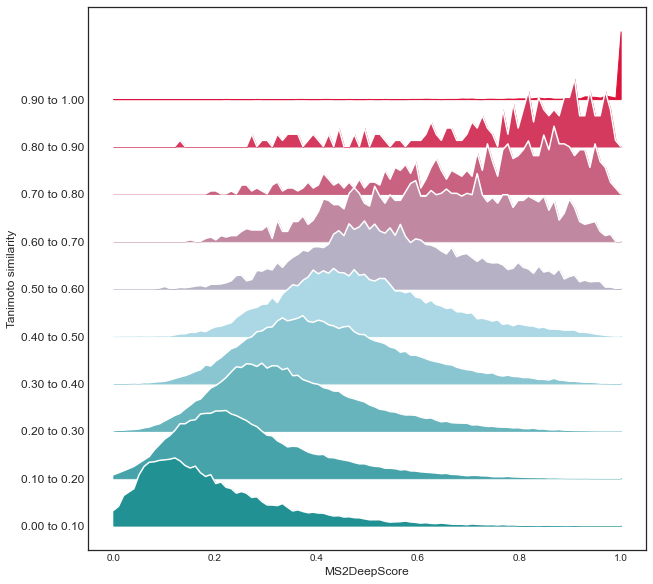

In [99]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

colors = ["crimson", "lightblue", "teal"]
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)


plt.figure(figsize=(10,10))
#fig, axes = plt.subplots(1, 1, sharex=True)
plt.style.use('seaborn-white')

shift = 0.7
alpha = 1.0 #0.5

tanimoto_bins = []
for i in range(n_bins):
    tanimoto_bins.append((i*d_bin, (i+1)*d_bin))
    
for i in range(0, len(histograms)):
    data = histograms[len(histograms)-i-1][0]
    data = data/max(data)
    plt.fill_between(histograms[0][1][:100], -shift*i, [(-shift*i + x) for x in data], color=cmap1(i/10), alpha=alpha)
    if i > 0:
        plt.plot(histograms[0][1][:100], [(-shift*i + x) for x in data], color="white")
    
plt.yticks(-shift*np.arange(len(histograms)),
           [f"{a:.2f} to {b:.2f}" for (a, b) in tanimoto_bins[::-1]], fontsize=12)
plt.xlabel("MS2DeepScore", fontsize=12)
plt.ylabel("Tanimoto similarity", fontsize=12)

In [73]:
epochs = 70
learning_rate = 0.001
metrics = ["mae"]

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

# Parameters
patience_scoring_net = 8
scoring_network_output_file = "scoring_network_201102_AllInchikey_cosine_large.hdf5"

scoring_network.compile(
    loss='mse',
    optimizer=Adam(learning_rate=learning_rate),
    metrics=metrics)

checkpointer = ModelCheckpoint(
    filepath = scoring_network_output_file,
    monitor='val_loss', mode="min",
    verbose=1,
    save_best_only=True
    )

earlystopper_scoring_net = EarlyStopping(
    monitor='val_loss', mode="min",
    patience=patience_scoring_net,
    verbose=1
    )

history = scoring_network.fit_generator(
    generator=train_generator,
    validation_data=val_generator,
    epochs = epochs,
    callbacks = [
        earlystopper_scoring_net,
        checkpointer,
        #TensorBoard(log_dir = os.path.join(ROOT, "tmp", "tensorboard", "{timestamp}"))
        ]
    )

Epoch 1/70
1626/1626 [==============================] - ETA: 0s - loss: 0.0655 - mae: 0.2079
Epoch 00001: val_loss improved from inf to 0.08206, saving model to scoring_network_201102_AllInchikey_cosine_large.hdf5
1626/1626 [==============================] - 291s 179ms/step - loss: 0.0655 - mae: 0.2079 - val_loss: 0.0821 - val_mae: 0.2222
Epoch 2/70
1626/1626 [==============================] - ETA: 0s - loss: 0.0527 - mae: 0.1814
Epoch 00002: val_loss improved from 0.08206 to 0.05572, saving model to scoring_network_201102_AllInchikey_cosine_large.hdf5
1626/1626 [==============================] - 284s 174ms/step - loss: 0.0527 - mae: 0.1814 - val_loss: 0.0557 - val_mae: 0.1784
Epoch 3/70
1626/1626 [==============================] - ETA: 0s - loss: 0.0480 - mae: 0.1714- ETA: 1s - loss: 0.0480 - mae: 
Epoch 00003: val_loss improved from 0.05572 to 0.04672, saving model to scoring_network_201102_AllInchikey_cosine_large.hdf5
1626/1626 [==============================] - 293s 180ms/step - l

KeyboardInterrupt: 

In [107]:
filename = "scoring_network_201028_AllInchikey_cosine.hdf5"
scoring_network = tf.keras.models.load_model(filename)

In [173]:
for layer in encoder.layers:
    print(layer.name)
    
print()
for layer in scoring_network.layers[2].layers:
    print(layer.name)

encoder_input
dense_101
dense_102
dense_103
dense_104

encoder_input
dense_101
dense_102
dropout_13
dense_103
dropout_14
dense_104


In [156]:
encoder.layers[6].get_weights()

[array([[-0.00762417, -0.08055832, -0.18315472, ...,  0.02573682,
         -0.02036016,  0.09090919],
        [-0.13698982, -0.08323934, -0.22824186, ..., -0.14861465,
          0.04177833,  0.12348736],
        [ 0.03306051, -0.06429061,  0.03143759, ...,  0.16391273,
          0.02445404, -0.15461229],
        ...,
        [ 0.09159587,  0.26503283,  0.01361432, ...,  0.03950302,
         -0.03976484, -0.1007341 ],
        [ 0.04722389,  0.3097378 , -0.03981756, ..., -0.07358153,
         -0.18612751, -0.03011231],
        [ 0.1453424 , -0.28920612,  0.02944349, ..., -0.05671837,
         -0.01500914, -0.179582  ]], dtype=float32),
 array([-3.59543674e-02, -1.16335511e-01, -2.66840477e-02, -6.87515438e-02,
         3.13331895e-02,  4.25182320e-02,  9.99536514e-02, -1.49877027e-01,
        -5.20262234e-02, -4.75987978e-02, -8.72951895e-02,  5.02421111e-02,
        -2.41603013e-02,  9.89296958e-02, -5.16600758e-02, -2.11480353e-02,
         2.31682733e-02,  1.00807257e-01,  5.88534726e

In [169]:
scoring_network.layers[2].layers[6].get_weights()

[array([[ 0.02432274, -0.07105273, -0.1679238 , ...,  0.0210899 ,
          0.02984896,  0.09166698],
        [-0.05479027, -0.09080488, -0.21855304, ..., -0.10357107,
          0.04228304,  0.12781452],
        [-0.03064503, -0.04605195, -0.07101826, ...,  0.11441099,
          0.04515796, -0.10445306],
        ...,
        [ 0.03987331,  0.11885088,  0.01862669, ...,  0.05240975,
         -0.04857946, -0.12447784],
        [ 0.04293461,  0.25964063, -0.01964482, ..., -0.06112565,
         -0.1580799 , -0.06606943],
        [ 0.14696774, -0.25324628,  0.00503219, ...,  0.0078143 ,
         -0.02732183, -0.13356456]], dtype=float32),
 array([-5.35034873e-02, -1.23298690e-01, -2.70555113e-02, -2.73268335e-02,
        -4.01088744e-02,  5.29237650e-02,  1.16506666e-01, -6.20792024e-02,
        -5.96268550e-02, -7.01727718e-02, -5.09975515e-02,  5.68059087e-02,
        -5.62700406e-02,  1.05975918e-01, -2.21728496e-02, -5.47838621e-02,
        -1.37847313e-03,  7.87547007e-02, -1.87461115e

In [174]:
embedding_dim = 400

# Encoder network
input_data  = Input(shape = (1, vector_dim), name="encoder_input")
encoding = Dense(embedding_dim, activation = 'relu', #kernel_regularizer=tf.keras.regularizers.l1(0.0001),
                 name="dense_101")(input_data)
encoding = Dense(embedding_dim, activation = 'relu', name="dense_102")(encoding)
encoding = Dense(embedding_dim, activation = 'relu', name="dense_103")(encoding)
encoding = Dense(embedding_dim, activation = 'relu', name="dense_104")(encoding)

encoder = Model(input_data, encoding)
for i, num in enumerate([0, 1, 2, 4, 6]):   
    encoder.layers[i].set_weights(scoring_network.layers[2].layers[num].get_weights())
encoder.summary()

Model: "functional_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 1, 9998)]         0         
_________________________________________________________________
dense_101 (Dense)            (None, 1, 400)            3999600   
_________________________________________________________________
dense_102 (Dense)            (None, 1, 400)            160400    
_________________________________________________________________
dense_103 (Dense)            (None, 1, 400)            160400    
_________________________________________________________________
dense_104 (Dense)            (None, 1, 400)            160400    
Total params: 4,480,800
Trainable params: 4,480,800
Non-trainable params: 0
_________________________________________________________________


In [175]:
encoder.layers[4].get_weights()

[array([[ 0.02432274, -0.07105273, -0.1679238 , ...,  0.0210899 ,
          0.02984896,  0.09166698],
        [-0.05479027, -0.09080488, -0.21855304, ..., -0.10357107,
          0.04228304,  0.12781452],
        [-0.03064503, -0.04605195, -0.07101826, ...,  0.11441099,
          0.04515796, -0.10445306],
        ...,
        [ 0.03987331,  0.11885088,  0.01862669, ...,  0.05240975,
         -0.04857946, -0.12447784],
        [ 0.04293461,  0.25964063, -0.01964482, ..., -0.06112565,
         -0.1580799 , -0.06606943],
        [ 0.14696774, -0.25324628,  0.00503219, ...,  0.0078143 ,
         -0.02732183, -0.13356456]], dtype=float32),
 array([-5.35034873e-02, -1.23298690e-01, -2.70555113e-02, -2.73268335e-02,
        -4.01088744e-02,  5.29237650e-02,  1.16506666e-01, -6.20792024e-02,
        -5.96268550e-02, -7.01727718e-02, -5.09975515e-02,  5.68059087e-02,
        -5.62700406e-02,  1.05975918e-01, -2.21728496e-02, -5.47838621e-02,
        -1.37847313e-03,  7.87547007e-02, -1.87461115e

In [112]:
# TODO: add symmetric nature of matrix to save factor 2

class DataGeneratorAllvsAll(Sequence):
    """Generates data for inference step (all-vs-all)"""
    def __init__(self, list_IDs, batch_size=32, dim=(10000,1), inchikey_mapping=None, inchikey_list=None):
        """Initialization"""
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.on_epoch_end()
        self.ID1 = 0
        self.ID2 = 0
        self.num_spectra = len(self.list_IDs)
        assert inchikey_mapping is not None, "needs inchikey mapping"
        self.inchikey_mapping = inchikey_mapping
        self.inchikey_list = inchikey_list

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return int(np.ceil(self.num_spectra / self.batch_size) * self.num_spectra)

    def __getitem__(self, index):
        """Generate one batch of data"""
        # Go through all x-y combinations
        pairs_list = []
        for i in range(self.batch_size):
            pairs_list.append((self.list_IDs[self.ID1], self.list_IDs[self.ID2]))
            self.ID2 += 1
            if self.ID2 >= self.num_spectra:
                self.ID2 = 0
                self.ID1 += 1
                if self.ID1 >= self.num_spectra:
                    self.ID1 = 0
                    print("job done...")
                break
        
        # Generate data
        X = self.__data_generation(pairs_list)

        return X

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        self.ID1 = 0
        self.ID2 = 0

    def __data_generation(self, pairs_list):
        """Generates data containing batch_size samples"""
        # Initialization
        X = [np.zeros((len(pairs_list), 1, self.dim)) for i in range(2)]
            
        ID1 = pairs_list[0][0]
        inchikey_1 = self.inchikey_mapping.loc[ID1]["inchikey"]
        ID1_all = np.where(self.inchikey_list == inchikey_1)[0][0]
        
        idx = np.array([x for x in spectrums_binned_dicts[ID1_all].keys()])
        X[0][:, 0, idx] = np.array([x for x in spectrums_binned_dicts[ID1_all].values()])
        
        # Generate data
        for i, IDs in enumerate(pairs_list):
            # Create binned spectrum vecotors and get similarity value
            inchikey_2 = self.inchikey_mapping.loc[IDs[1]]["inchikey"]
            ID2_all = np.where(self.inchikey_list == inchikey_2)[0][0]
            idx = np.array([x for x in spectrums_binned_dicts[ID2_all].keys()])
            X[1][i, 0, idx] = np.array([x for x in spectrums_binned_dicts[ID2_all].values()])

        return X

In [119]:
vector_dim

9998

In [129]:
A, B = val_generator.__getitem__(0)
A[0].shape, A[1].shape, B

((16, 1, 9998),
 (16, 1, 9998),
 array([0.10500808, 0.75046382, 1.        , 0.51123596, 0.17627945,
        0.13138686, 0.35516373, 0.60745614, 1.        , 0.20197044,
        0.50803324, 0.32354903, 0.10899183, 0.13745271, 0.21052632,
        0.11185087]))

In [162]:
A[0][0].sum()

6.718115032985305

In [133]:
from matchms.similarity.vector_similarity_functions import cosine_similarity_matrix, cosine_similarity

In [178]:
encoder.predict(A[1][10].reshape(1, -1)).reshape(-1)

array([0.33712444, 0.37970698, 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.7613822 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.42770416, 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.0140023 , 0.        , 1.9741247 ,
       0.        , 0.        , 0.        , 0.        , 1.4487575 ,
       0.        , 0.        , 0.        , 0.        , 2.467546  ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [176]:
[cosine_similarity(encoder.predict(A[0][i].reshape(1, -1)).reshape(-1),
                   encoder.predict(A[1][i].reshape(1, -1)).reshape(-1)) for i in range(16)]

[0.07469243069891086,
 0.7394902091014481,
 0.9599947533339933,
 0.23481554833373852,
 0.33737776426747135,
 0.1050147314618275,
 0.4709859843625213,
 0.4996891178153571,
 0.7981817843683724,
 0.25221960734351,
 0.4738075319316898,
 0.5214670861434217,
 0.17966238184834252,
 0.24556358105204515,
 0.4461910190909424,
 0.23589679915144726]

In [147]:
scoring_network.predict(A).reshape(-1)

array([0.07469243, 0.73949015, 0.9599947 , 0.23481552, 0.33737767,
       0.10501474, 0.47098604, 0.49968898, 0.7981817 , 0.25221956,
       0.47380754, 0.52146703, 0.17966233, 0.24556358, 0.44619095,
       0.2358968 ], dtype=float32)

In [120]:
matrix_dim = len(testIDs)
predict_generator = DataGeneratorAllvsAll(testIDs, batch_size=1085, dim=(vector_dim),
                                         inchikey_mapping=metadata, inchikey_list=inchikeys_array)
print(predict_generator.ID1, predict_generator.ID2)

import time
tstart = time.time()
predict_generator.ID1 = 0
scores_predicted_test = scoring_network.predict(predict_generator, verbose=1)
tstop = time.time()
print(tstop-tstart)

scores_test = np.roll(scores_predicted_test, predict_generator.batch_size).reshape(matrix_dim, matrix_dim)

0 0
1085/1085 [==============================] - 3863s 4s/step
3868.382185459137


In [121]:
scores_test_commutative = (scores_test + scores_test.T)/2

In [123]:
scores_ref = scores_mol_similarity[np.ix_(testIDs[:matrix_dim], testIDs[:matrix_dim])]

In [124]:
n_bins = 10
d_bin = 1/n_bins
hist_bins = np.linspace(0, 1, 100) 
hist_bins = np.concatenate((hist_bins, np.array([2.0])))

histograms = []
for i in range(n_bins):
    idx = np.where((scores_ref > i*d_bin) & (scores_ref <= (i + 1) * d_bin))
    a, b = np.histogram(scores_test_commutative[idx], bins=hist_bins)
    histograms.append((a, b))

Text(0, 0.5, 'Tanimoto similarity')

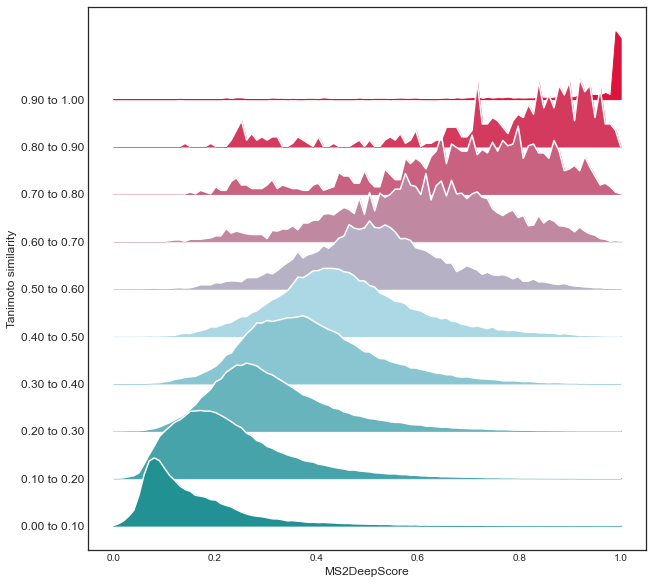

In [125]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

colors = ["crimson", "lightblue", "teal"]
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)


plt.figure(figsize=(10,10))
#fig, axes = plt.subplots(1, 1, sharex=True)
plt.style.use('seaborn-white')

shift = 0.7
alpha = 1.0 #0.5

tanimoto_bins = []
for i in range(n_bins):
    tanimoto_bins.append((i*d_bin, (i+1)*d_bin))
    
for i in range(0, len(histograms)):
    data = histograms[len(histograms)-i-1][0]
    data = data/max(data)
    plt.fill_between(histograms[0][1][:100], -shift*i, [(-shift*i + x) for x in data], color=cmap1(i/10), alpha=alpha)
    if i > 0:
        plt.plot(histograms[0][1][:100], [(-shift*i + x) for x in data], color="white")
    
plt.yticks(-shift*np.arange(len(histograms)),
           [f"{a:.2f} to {b:.2f}" for (a, b) in tanimoto_bins[::-1]], fontsize=12)
plt.xlabel("MS2DeepScore", fontsize=12)
plt.ylabel("Tanimoto similarity", fontsize=12)

In [126]:
n_bins = 10
d_bin = 1/n_bins
hist_bins = np.linspace(0, 1, 100) 
hist_bins = np.concatenate((hist_bins, np.array([2.0])))

histograms = []
for i in range(n_bins):
    idx = np.where((scores_test_commutative > i*d_bin) & (scores_test_commutative <= (i + 1) * d_bin))
    a, b = np.histogram(scores_ref[idx], bins=hist_bins)
    histograms.append((a, b))

Text(0.5, 0, 'Tanimoto similarity')

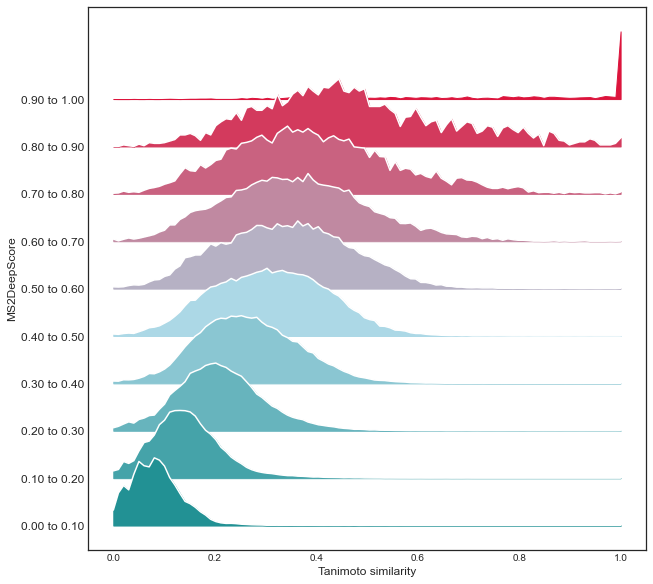

In [127]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

colors = ["crimson", "lightblue", "teal"]
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)


plt.figure(figsize=(10,10))
#fig, axes = plt.subplots(1, 1, sharex=True)
plt.style.use('seaborn-white')

shift = 0.7
alpha = 1.0 #0.5

tanimoto_bins = []
for i in range(n_bins):
    tanimoto_bins.append((i*d_bin, (i+1)*d_bin))
    
for i in range(0, len(histograms)):
    data = histograms[len(histograms)-i-1][0]
    data = data/max(data)
    plt.fill_between(histograms[0][1][:100], -shift*i, [(-shift*i + x) for x in data], color=cmap1(i/10), alpha=alpha)
    if i > 0:
        plt.plot(histograms[0][1][:100], [(-shift*i + x) for x in data], color="white")
    
plt.yticks(-shift*np.arange(len(histograms)),
           [f"{a:.2f} to {b:.2f}" for (a, b) in tanimoto_bins[::-1]], fontsize=12)
plt.ylabel("MS2DeepScore", fontsize=12)
plt.xlabel("Tanimoto similarity", fontsize=12)

## Again dropout but with more variation in data augmentation

In [222]:
embedding_dim = 400
dropout_rate = 0.1
#gaussian_noice = 0.025
print("Vector dimension:", vector_dim)

# Encoder network
input_data  = Input(shape = (1, vector_dim), name="encoder_input")
encoding = Dense(embedding_dim, activation = 'relu', #kernel_regularizer=tf.keras.regularizers.l1(0.0001),
                 name="dense_101")(input_data)
#encoding = GaussianNoise(gaussian_noice)(encoding)
encoding = Dense(embedding_dim, activation = 'relu', name="dense_102")(encoding)
encoding = Dropout(dropout_rate)(encoding)
encoding = Dense(embedding_dim, activation = 'relu', name="dense_103")(encoding)
encoding = Dropout(dropout_rate)(encoding)
encoding = Dense(embedding_dim, activation = 'relu', name="dense_104")(encoding)

encoder = Model(input_data, encoding)

# Scoring network
spectrum1 = Input(shape = (1, vector_dim), name="scoring_input1")
spectrum2 = Input(shape = (1, vector_dim), name="scoring_input2")

embedding1 = encoder(spectrum1)
embedding2 = encoder(spectrum2)

cosine_similarity = Dot(axes=(2, 2), normalize=True, name="cosine_similarity")([embedding1, embedding2])

scoring_network = Model(inputs=[spectrum1, spectrum2], outputs = [cosine_similarity])

scoring_network.summary()
encoder.summary()

Vector dimension: 9998
Model: "functional_71"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
scoring_input1 (InputLayer)     [(None, 1, 9998)]    0                                            
__________________________________________________________________________________________________
scoring_input2 (InputLayer)     [(None, 1, 9998)]    0                                            
__________________________________________________________________________________________________
functional_69 (Functional)      (None, 1, 400)       4480800     scoring_input1[0][0]             
                                                                 scoring_input2[0][0]             
__________________________________________________________________________________________________
cosine_similarity (Dot)         (None, 1, 1)         0         

In [223]:
same_prob_bins = list(zip(0.1*np.arange(10), (0.1 + 0.1*np.arange(10))))

train_generator = DataGeneratorAllInchikey(trainIDs, batch_size=16, num_turns=2, dim=(vector_dim), n_channels=1,
                                           n_classes=1, shuffle=True,
                                           score_array=scores_mol_similarity, 
                                           inchikey_mapping=metadata, inchikey_list = inchikeys_array,
                                           same_prob_bins=same_prob_bins,
                                           augment_peak_removal={"max_removal": 0.4, "max_intensity": 0.1**0.5},
                                           augment_intensity=0.4)

val_generator = DataGeneratorAllInchikey(valIDs, batch_size=16, num_turns=1, dim=(vector_dim), n_channels=1,
                                         n_classes=1, shuffle=True,
                                         score_array=scores_mol_similarity, 
                                         inchikey_mapping=metadata, inchikey_list = inchikeys_array,
                                         same_prob_bins=same_prob_bins,
                                         augment_peak_removal={"max_removal": 0.01, "max_intensity": 0.01},
                                         augment_intensity=0.01)

In [224]:
epochs = 70
learning_rate = 0.0005
metrics = ["accuracy"]

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

# Parameters
patience_scoring_net = 8
scoring_network_output_file = "scoring_network_20131_AllInchikey_cosine.hdf5"

scoring_network.compile(
    loss='mse',
    optimizer=Adam(learning_rate=learning_rate),
    metrics=metrics)

checkpointer = ModelCheckpoint(
    filepath = scoring_network_output_file,
    # monitor='val_accuracy',
    monitor='val_loss', mode="min",
    verbose=1,
    save_best_only=True
    )

earlystopper_scoring_net = EarlyStopping(
    # monitor='val_accuracy',
    monitor='val_loss', mode="min",
    patience=patience_scoring_net,
    verbose=1
    )

scoring_network.fit_generator(
    generator=train_generator,
    validation_data=val_generator,
    epochs = epochs,
    callbacks = [
        earlystopper_scoring_net,
        checkpointer,
        #TensorBoard(log_dir = os.path.join(ROOT, "tmp", "tensorboard", "{timestamp}"))
        ]
    )

Epoch 1/70
1536/1536 [==============================] - ETA: 0s - loss: 0.0562 - accuracy: 0.0603
Epoch 00001: val_loss improved from inf to 0.05410, saving model to scoring_network_20131_AllInchikey_cosine.hdf5
1536/1536 [==============================] - 225s 147ms/step - loss: 0.0562 - accuracy: 0.0603 - val_loss: 0.0541 - val_accuracy: 0.0914
Epoch 2/70
1536/1536 [==============================] - ETA: 0s - loss: 0.0470 - accuracy: 0.0589 ETA: 2s
Epoch 00002: val_loss improved from 0.05410 to 0.04330, saving model to scoring_network_20131_AllInchikey_cosine.hdf5
1536/1536 [==============================] - 205s 133ms/step - loss: 0.0470 - accuracy: 0.0589 - val_loss: 0.0433 - val_accuracy: 0.0821
Epoch 3/70
1536/1536 [==============================] - ETA: 0s - loss: 0.0434 - accuracy: 0.0590
Epoch 00003: val_loss did not improve from 0.04330
1536/1536 [==============================] - 195s 127ms/step - loss: 0.0434 - accuracy: 0.0590 - val_loss: 0.0459 - val_accuracy: 0.0718
Epoc

Epoch 27/70
1536/1536 [==============================] - ETA: 0s - loss: 0.0211 - accuracy: 0.0590
Epoch 00027: val_loss did not improve from 0.02642
1536/1536 [==============================] - 207s 134ms/step - loss: 0.0211 - accuracy: 0.0590 - val_loss: 0.0298 - val_accuracy: 0.0812
Epoch 28/70
1536/1536 [==============================] - ETA: 0s - loss: 0.0206 - accuracy: 0.0620
Epoch 00028: val_loss did not improve from 0.02642
1536/1536 [==============================] - 200s 130ms/step - loss: 0.0206 - accuracy: 0.0620 - val_loss: 0.0275 - val_accuracy: 0.0774
Epoch 29/70
1536/1536 [==============================] - ETA: 0s - loss: 0.0209 - accuracy: 0.0607
Epoch 00029: val_loss did not improve from 0.02642
1536/1536 [==============================] - 193s 125ms/step - loss: 0.0209 - accuracy: 0.0607 - val_loss: 0.0294 - val_accuracy: 0.0849
Epoch 30/70
1536/1536 [==============================] - ETA: 0s - loss: 0.0203 - accuracy: 0.0618
Epoch 00030: val_loss did not improve fr

In [243]:
filename = "scoring_network_20131_AllInchikey_cosine.hdf5"
scoring_network = tf.keras.models.load_model(filename)

In [226]:
#def create_similarity_matrix(IDs, embedding_dim, encoder, inchikey_mapping, inchikey_list):
    
def get_embedding_array(IDs, embedding_dim, encoder, inchikey_mapping, inchikey_list):
    embeddings = np.zeros((len(IDs), embedding_dim))
    for i, ID in enumerate(IDs):
        X = np.zeros((1, encoder.input_shape[2]))
        inchikey = inchikey_mapping.loc[ID]["inchikey"]
        ID1_all = np.where(inchikey_list == inchikey)[0][0]
        idx = np.array([x for x in spectrums_binned_dicts[ID1_all].keys()])
        X[0, idx] = np.array([x for x in spectrums_binned_dicts[ID1_all].values()])
        embeddings[i, :] = encoder.predict(X)

    return embeddings

embeddings = get_embedding_array(testIDs, embedding_dim, encoder, metadata, inchikeys_array)

In [227]:
embeddings.shape

(1085, 400)

In [228]:
MS2DS_scores = cosine_similarity_matrix(embeddings, embeddings)

In [229]:
n_bins = 10
d_bin = 1/n_bins
hist_bins = np.linspace(0, 1, 100) 
hist_bins = np.concatenate((hist_bins, np.array([2.0])))

histograms = []
for i in range(n_bins):
    idx = np.where((scores_ref > i*d_bin) & (scores_ref <= (i + 1) * d_bin))
    a, b = np.histogram(MS2DS_scores[idx], bins=hist_bins)
    histograms.append((a, b))

Text(0, 0.5, 'Tanimoto similarity')

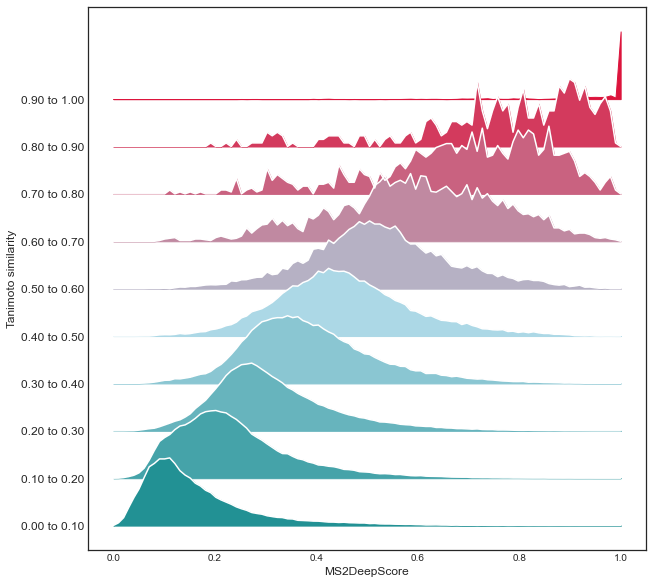

In [230]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

colors = ["crimson", "lightblue", "teal"]
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)


plt.figure(figsize=(10,10))
#fig, axes = plt.subplots(1, 1, sharex=True)
plt.style.use('seaborn-white')

shift = 0.7
alpha = 1.0 #0.5

tanimoto_bins = []
for i in range(n_bins):
    tanimoto_bins.append((i*d_bin, (i+1)*d_bin))
    
for i in range(0, len(histograms)):
    data = histograms[len(histograms)-i-1][0]
    data = data/max(data)
    plt.fill_between(histograms[0][1][:100], -shift*i, [(-shift*i + x) for x in data], color=cmap1(i/10), alpha=alpha)
    if i > 0:
        plt.plot(histograms[0][1][:100], [(-shift*i + x) for x in data], color="white")
    
plt.yticks(-shift*np.arange(len(histograms)),
           [f"{a:.2f} to {b:.2f}" for (a, b) in tanimoto_bins[::-1]], fontsize=12)
plt.xlabel("MS2DeepScore", fontsize=12)
plt.ylabel("Tanimoto similarity", fontsize=12)

## Try larger network (and prune later?) AND L1 regularization for 1st layer?

In [241]:
dense_dims = [600, 600, 500, 400]
dropout_rate = 0.2
#gaussian_noice = 0.025
print("Vector dimension:", vector_dim)

# Encoder network
input_data  = Input(shape = (1, vector_dim), name="encoder_input")
encoding = Dense(dense_dims[0], activation = 'relu', kernel_regularizer=tf.keras.regularizers.l1(1e-6),
                 name="dense_101")(input_data)
#encoding = GaussianNoise(gaussian_noice)(encoding)
encoding = Dense(dense_dims[1], activation = 'relu', name="dense_102")(encoding)
encoding = Dropout(dropout_rate)(encoding)
encoding = Dense(dense_dims[2], activation = 'relu', name="dense_103")(encoding)
encoding = Dropout(dropout_rate)(encoding)
encoding = Dense(dense_dims[3], activation = 'relu', name="dense_104")(encoding)

encoder = Model(input_data, encoding)

# Scoring network
spectrum1 = Input(shape = (1, vector_dim), name="scoring_input1")
spectrum2 = Input(shape = (1, vector_dim), name="scoring_input2")

embedding1 = encoder(spectrum1)
embedding2 = encoder(spectrum2)

cosine_similarity = Dot(axes=(2, 2), normalize=True, name="cosine_similarity")([embedding1, embedding2])

scoring_network = Model(inputs=[spectrum1, spectrum2], outputs = [cosine_similarity])

scoring_network.summary()
encoder.summary()

Vector dimension: 9998
Model: "functional_95"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
scoring_input1 (InputLayer)     [(None, 1, 9998)]    0                                            
__________________________________________________________________________________________________
scoring_input2 (InputLayer)     [(None, 1, 9998)]    0                                            
__________________________________________________________________________________________________
functional_93 (Functional)      (None, 1, 400)       6860900     scoring_input1[0][0]             
                                                                 scoring_input2[0][0]             
__________________________________________________________________________________________________
cosine_similarity (Dot)         (None, 1, 1)         0         

In [238]:
same_prob_bins = list(zip(0.1*np.arange(10), (0.1 + 0.1*np.arange(10))))

train_generator = DataGeneratorAllInchikey(trainIDs, batch_size=16, num_turns=2, dim=(vector_dim), n_channels=1,
                                           n_classes=1, shuffle=True,
                                           score_array=scores_mol_similarity, 
                                           inchikey_mapping=metadata, inchikey_list = inchikeys_array,
                                           same_prob_bins=same_prob_bins,
                                           augment_peak_removal={"max_removal": 0.4, "max_intensity": 0.1**0.5},
                                           augment_intensity=0.4)

val_generator = DataGeneratorAllInchikey(valIDs, batch_size=16, num_turns=1, dim=(vector_dim), n_channels=1,
                                         n_classes=1, shuffle=True,
                                         score_array=scores_mol_similarity, 
                                         inchikey_mapping=metadata, inchikey_list = inchikeys_array,
                                         same_prob_bins=same_prob_bins,
                                         augment_peak_removal={"max_removal": 0.01, "max_intensity": 0.01},
                                         augment_intensity=0.01)

In [242]:
epochs = 70
learning_rate = 0.001
metrics = ["mae"]

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

# Parameters
patience_scoring_net = 8
scoring_network_output_file = "scoring_network_20131_AllInchikey_cosine_larger.hdf5"

scoring_network.compile(
    loss='mse',
    optimizer=Adam(learning_rate=learning_rate),
    metrics=metrics)

checkpointer = ModelCheckpoint(
    filepath = scoring_network_output_file,
    # monitor='val_accuracy',
    monitor='val_loss', mode="min",
    verbose=1,
    save_best_only=True
    )

earlystopper_scoring_net = EarlyStopping(
    # monitor='val_accuracy',
    monitor='val_loss', mode="min",
    patience=patience_scoring_net,
    verbose=1
    )

scoring_network.fit_generator(
    generator=train_generator,
    validation_data=val_generator,
    epochs = epochs,
    callbacks = [
        earlystopper_scoring_net,
        checkpointer,
        #TensorBoard(log_dir = os.path.join(ROOT, "tmp", "tensorboard", "{timestamp}"))
        ]
    )

Epoch 1/70
1536/1536 [==============================] - ETA: 0s - loss: 0.1118 - mae: 0.2020
Epoch 00001: val_loss improved from inf to 0.11956, saving model to scoring_network_20131_AllInchikey_cosine_larger.hdf5
1536/1536 [==============================] - 287s 187ms/step - loss: 0.1118 - mae: 0.2020 - val_loss: 0.1196 - val_mae: 0.2019
Epoch 2/70
1536/1536 [==============================] - ETA: 0s - loss: 0.0996 - mae: 0.1795
Epoch 00002: val_loss improved from 0.11956 to 0.09608, saving model to scoring_network_20131_AllInchikey_cosine_larger.hdf5
1536/1536 [==============================] - 286s 186ms/step - loss: 0.0996 - mae: 0.1795 - val_loss: 0.0961 - val_mae: 0.1699
Epoch 3/70
1536/1536 [==============================] - ETA: 0s - loss: 0.0952 - mae: 0.1740- ETA: 1s - loss: 0.0951 - ma
Epoch 00003: val_loss improved from 0.09608 to 0.09546, saving model to scoring_network_20131_AllInchikey_cosine_larger.hdf5
1536/1536 [==============================] - 260s 169ms/step - loss

Epoch 27/70
1536/1536 [==============================] - ETA: 0s - loss: 0.0612 - mae: 0.1340
Epoch 00027: val_loss did not improve from 0.06093
1536/1536 [==============================] - 224s 146ms/step - loss: 0.0612 - mae: 0.1340 - val_loss: 0.0673 - val_mae: 0.1424
Epoch 28/70
1536/1536 [==============================] - ETA: 0s - loss: 0.0598 - mae: 0.1318
Epoch 00028: val_loss did not improve from 0.06093
1536/1536 [==============================] - 227s 148ms/step - loss: 0.0598 - mae: 0.1318 - val_loss: 0.0612 - val_mae: 0.1328
Epoch 29/70
1536/1536 [==============================] - ETA: 0s - loss: 0.0588 - mae: 0.1313
Epoch 00029: val_loss did not improve from 0.06093
1536/1536 [==============================] - 231s 150ms/step - loss: 0.0588 - mae: 0.1313 - val_loss: 0.0630 - val_mae: 0.1379
Epoch 30/70
1536/1536 [==============================] - ETA: 0s - loss: 0.0580 - mae: 0.1294
Epoch 00030: val_loss improved from 0.06093 to 0.06091, saving model to scoring_network_20

In [244]:
filename = "scoring_network_20131_AllInchikey_cosine_larger.hdf5"
scoring_network = tf.keras.models.load_model(filename)

In [245]:
#def create_similarity_matrix(IDs, embedding_dim, encoder, inchikey_mapping, inchikey_list):
    
def get_embedding_array(IDs, embedding_dim, encoder, inchikey_mapping, inchikey_list):
    embeddings = np.zeros((len(IDs), embedding_dim))
    for i, ID in enumerate(IDs):
        X = np.zeros((1, encoder.input_shape[2]))
        inchikey = inchikey_mapping.loc[ID]["inchikey"]
        ID1_all = np.where(inchikey_list == inchikey)[0][0]
        idx = np.array([x for x in spectrums_binned_dicts[ID1_all].keys()])
        X[0, idx] = np.array([x for x in spectrums_binned_dicts[ID1_all].values()])
        embeddings[i, :] = encoder.predict(X)

    return embeddings

embeddings = get_embedding_array(testIDs, embedding_dim, encoder, metadata, inchikeys_array)

In [246]:
embeddings.shape

(1085, 400)

In [247]:
MS2DS_scores = cosine_similarity_matrix(embeddings, embeddings)

In [248]:
n_bins = 10
d_bin = 1/n_bins
hist_bins = np.linspace(0, 1, 100) 
hist_bins = np.concatenate((hist_bins, np.array([2.0])))

histograms = []
for i in range(n_bins):
    idx = np.where((scores_ref > i*d_bin) & (scores_ref <= (i + 1) * d_bin))
    a, b = np.histogram(MS2DS_scores[idx], bins=hist_bins)
    histograms.append((a, b))

Text(0, 0.5, 'Tanimoto similarity')

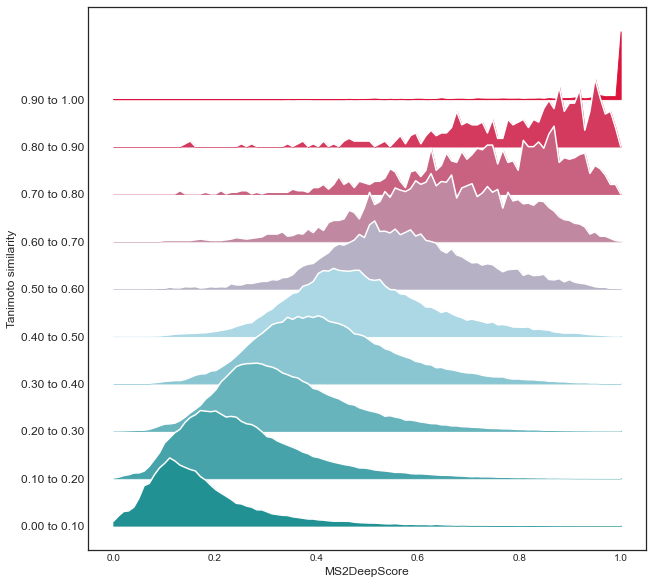

In [249]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

colors = ["crimson", "lightblue", "teal"]
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)


plt.figure(figsize=(10,10))
#fig, axes = plt.subplots(1, 1, sharex=True)
plt.style.use('seaborn-white')

shift = 0.7
alpha = 1.0 #0.5

tanimoto_bins = []
for i in range(n_bins):
    tanimoto_bins.append((i*d_bin, (i+1)*d_bin))
    
for i in range(0, len(histograms)):
    data = histograms[len(histograms)-i-1][0]
    data = data/max(data)
    plt.fill_between(histograms[0][1][:100], -shift*i, [(-shift*i + x) for x in data], color=cmap1(i/10), alpha=alpha)
    if i > 0:
        plt.plot(histograms[0][1][:100], [(-shift*i + x) for x in data], color="white")
    
plt.yticks(-shift*np.arange(len(histograms)),
           [f"{a:.2f} to {b:.2f}" for (a, b) in tanimoto_bins[::-1]], fontsize=12)
plt.xlabel("MS2DeepScore", fontsize=12)
plt.ylabel("Tanimoto similarity", fontsize=12)

In [250]:
n_bins = 10
d_bin = 1/n_bins
hist_bins = np.linspace(0, 1, 100) 
hist_bins = np.concatenate((hist_bins, np.array([2.0])))

histograms = []
for i in range(n_bins):
    idx = np.where((MS2DS_scores > i*d_bin) & (MS2DS_scores <= (i + 1) * d_bin))
    a, b = np.histogram(scores_ref[idx], bins=hist_bins)
    histograms.append((a, b))

Text(0.5, 0, 'Tanimoto similarity')

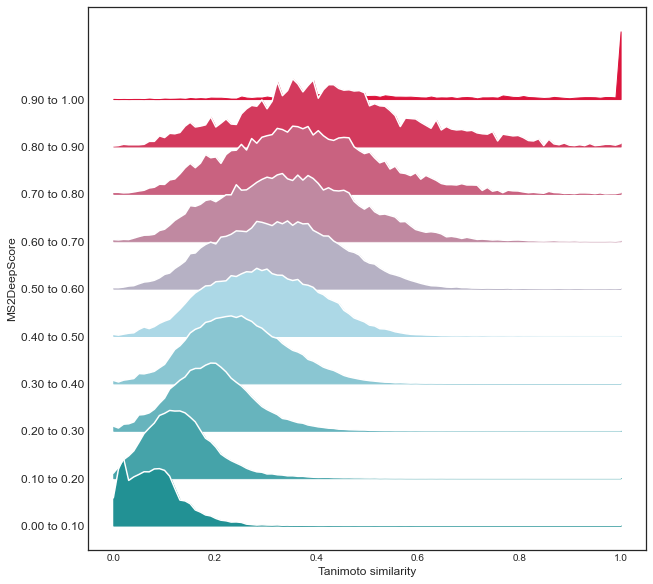

In [251]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

colors = ["crimson", "lightblue", "teal"]
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)


plt.figure(figsize=(10,10))
#fig, axes = plt.subplots(1, 1, sharex=True)
plt.style.use('seaborn-white')

shift = 0.7
alpha = 1.0 #0.5

tanimoto_bins = []
for i in range(n_bins):
    tanimoto_bins.append((i*d_bin, (i+1)*d_bin))
    
for i in range(0, len(histograms)):
    data = histograms[len(histograms)-i-1][0]
    data = data/max(data)
    plt.fill_between(histograms[0][1][:100], -shift*i, [(-shift*i + x) for x in data], color=cmap1(i/10), alpha=alpha)
    if i > 0:
        plt.plot(histograms[0][1][:100], [(-shift*i + x) for x in data], color="white")
    
plt.yticks(-shift*np.arange(len(histograms)),
           [f"{a:.2f} to {b:.2f}" for (a, b) in tanimoto_bins[::-1]], fontsize=12)
plt.ylabel("MS2DeepScore", fontsize=12)
plt.xlabel("Tanimoto similarity", fontsize=12)

## Not too great: L2 regularization

In [214]:
embedding_dim = 400
#dropout_rate = 0.1
gaussian_noice = 0.025
regularization_rate = 1e-5
print("Vector dimension:", vector_dim)

# Encoder network
input_data  = Input(shape = (1, vector_dim), name="encoder_input")
encoding = Dense(embedding_dim, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(regularization_rate),
                 name="dense_101")(input_data)
#encoding = GaussianNoise(gaussian_noice)(encoding)
encoding = Dense(embedding_dim, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(regularization_rate),
                 name="dense_102")(encoding)
#encoding = GaussianNoise(gaussian_noice)(encoding)
encoding = Dense(embedding_dim, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(regularization_rate),
                 name="dense_103")(encoding)
#encoding = GaussianNoise(gaussian_noice)(encoding)
encoding = Dense(embedding_dim, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(regularization_rate),
                 name="dense_104")(encoding)

encoder = Model(input_data, encoding)

# Scoring network
spectrum1 = Input(shape = (1, vector_dim), name="scoring_input1")
spectrum2 = Input(shape = (1, vector_dim), name="scoring_input2")

embedding1 = encoder(spectrum1)
embedding2 = encoder(spectrum2)

cosine_similarity = Dot(axes=(2, 2), normalize=True, name="cosine_similarity")([embedding1, embedding2])

scoring_network = Model(inputs=[spectrum1, spectrum2], outputs = [cosine_similarity])

scoring_network.summary()
encoder.summary()

Vector dimension: 9998
Model: "functional_67"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
scoring_input1 (InputLayer)     [(None, 1, 9998)]    0                                            
__________________________________________________________________________________________________
scoring_input2 (InputLayer)     [(None, 1, 9998)]    0                                            
__________________________________________________________________________________________________
functional_65 (Functional)      (None, 1, 400)       4480800     scoring_input1[0][0]             
                                                                 scoring_input2[0][0]             
__________________________________________________________________________________________________
cosine_similarity (Dot)         (None, 1, 1)         0         

In [211]:
prob_bins = 15
same_prob_bins = list(zip(1/prob_bins*np.arange(prob_bins), (1/prob_bins + 1/prob_bins*np.arange(prob_bins))))

train_generator = DataGeneratorAllInchikey(trainIDs, batch_size=24, num_turns=2, dim=(vector_dim), n_channels=1,
                                           n_classes=1, shuffle=True,
                                           score_array=scores_mol_similarity, 
                                           inchikey_mapping=metadata, inchikey_list = inchikeys_array,
                                           same_prob_bins=same_prob_bins,
                                           augment_peak_removal={"max_removal": 0.2, "max_intensity": 0.1**0.5},
                                           augment_intensity=0.3)

val_generator = DataGeneratorAllInchikey(valIDs, batch_size=24, num_turns=1, dim=(vector_dim), n_channels=1,
                                         n_classes=1, shuffle=True,
                                         score_array=scores_mol_similarity, 
                                         inchikey_mapping=metadata, inchikey_list = inchikeys_array,
                                         same_prob_bins=same_prob_bins,
                                         augment_peak_removal={"max_removal": 0.1, "max_intensity": 0.1**0.5},
                                         augment_intensity=0.1)

In [215]:
epochs = 70
learning_rate = 0.01
metrics = ["accuracy"]

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

# Parameters
patience_scoring_net = 8
scoring_network_output_file = "scoring_network_201029_AllInchikey_L2Reg_cosine.hdf5"

scoring_network.compile(
    loss='mse',
    optimizer=Adam(learning_rate=learning_rate),
    metrics=metrics)

checkpointer = ModelCheckpoint(
    filepath = scoring_network_output_file,
    # monitor='val_accuracy',
    monitor='val_loss', mode="min",
    verbose=1,
    save_best_only=True
    )

earlystopper_scoring_net = EarlyStopping(
    # monitor='val_accuracy',
    monitor='val_loss', mode="min",
    patience=patience_scoring_net,
    verbose=1
    )

scoring_network.fit_generator(
    generator=train_generator,
    validation_data=val_generator,
    epochs = epochs,
    callbacks = [
        earlystopper_scoring_net,
        checkpointer,
        #TensorBoard(log_dir = os.path.join(ROOT, "tmp", "tensorboard", "{timestamp}"))
        ]
    )

Epoch 1/70
1024/1024 [==============================] - ETA: 0s - loss: 0.1988 - accuracy: 0.04146-  - ETA: 2s - loss: 0
Epoch 00001: val_loss improved from inf to 0.18919, saving model to scoring_network_201029_AllInchikey_L2Reg_cosine.hdf5
1024/1024 [==============================] - 239s 233ms/step - loss: 0.1988 - accuracy: 0.0414 - val_loss: 0.1892 - val_accuracy: 0.0574
Epoch 2/70
1024/1024 [==============================] - ETA: 0s - loss: 0.1767 - accuracy: 0.0439
Epoch 00002: val_loss improved from 0.18919 to 0.18049, saving model to scoring_network_201029_AllInchikey_L2Reg_cosine.hdf5
1024/1024 [==============================] - 212s 207ms/step - loss: 0.1767 - accuracy: 0.0439 - val_loss: 0.1805 - val_accuracy: 0.0667
Epoch 3/70
1024/1024 [==============================] - ETA: 0s - loss: 0.1586 - accuracy: 0.0415
Epoch 00003: val_loss improved from 0.18049 to 0.14302, saving model to scoring_network_201029_AllInchikey_L2Reg_cosine.hdf5
1024/1024 [===========================

Epoch 26/70
1024/1024 [==============================] - ETA: 0s - loss: 0.0817 - accuracy: 0.0444
Epoch 00026: val_loss improved from 0.07718 to 0.07657, saving model to scoring_network_201029_AllInchikey_L2Reg_cosine.hdf5
1024/1024 [==============================] - 160s 156ms/step - loss: 0.0817 - accuracy: 0.0444 - val_loss: 0.0766 - val_accuracy: 0.0565
Epoch 27/70
1024/1024 [==============================] - ETA: 0s - loss: 0.0832 - accuracy: 0.0423
Epoch 00027: val_loss did not improve from 0.07657
1024/1024 [==============================] - 173s 169ms/step - loss: 0.0832 - accuracy: 0.0423 - val_loss: 0.0775 - val_accuracy: 0.0611
Epoch 28/70
1024/1024 [==============================] - ETA: 0s - loss: 0.0819 - accuracy: 0.0419
Epoch 00028: val_loss improved from 0.07657 to 0.07128, saving model to scoring_network_201029_AllInchikey_L2Reg_cosine.hdf5
1024/1024 [==============================] - 160s 156ms/step - loss: 0.0819 - accuracy: 0.0419 - val_loss: 0.0713 - val_accuracy

In [216]:
filename = "scoring_network_201029_AllInchikey_L2Reg_cosine.hdf5"
scoring_network = tf.keras.models.load_model(filename)

In [217]:
#def create_similarity_matrix(IDs, embedding_dim, encoder, inchikey_mapping, inchikey_list):
    
def get_embedding_array(IDs, embedding_dim, encoder, inchikey_mapping, inchikey_list):
    embeddings = np.zeros((len(IDs), embedding_dim))
    for i, ID in enumerate(IDs):
        X = np.zeros((1, encoder.input_shape[2]))
        inchikey = inchikey_mapping.loc[ID]["inchikey"]
        ID1_all = np.where(inchikey_list == inchikey)[0][0]
        idx = np.array([x for x in spectrums_binned_dicts[ID1_all].keys()])
        X[0, idx] = np.array([x for x in spectrums_binned_dicts[ID1_all].values()])
        embeddings[i, :] = encoder.predict(X)

    return embeddings

embeddings = get_embedding_array(testIDs, embedding_dim, encoder, metadata, inchikeys_array)

In [218]:
embeddings.shape

(1085, 400)

In [219]:
MS2DS_scores = cosine_similarity_matrix(embeddings, embeddings)

In [220]:
n_bins = 10
d_bin = 1/n_bins
hist_bins = np.linspace(0, 1, 100) 
hist_bins = np.concatenate((hist_bins, np.array([2.0])))

histograms = []
for i in range(n_bins):
    idx = np.where((scores_ref > i*d_bin) & (scores_ref <= (i + 1) * d_bin))
    a, b = np.histogram(MS2DS_scores[idx], bins=hist_bins)
    histograms.append((a, b))

Text(0, 0.5, 'Tanimoto similarity')

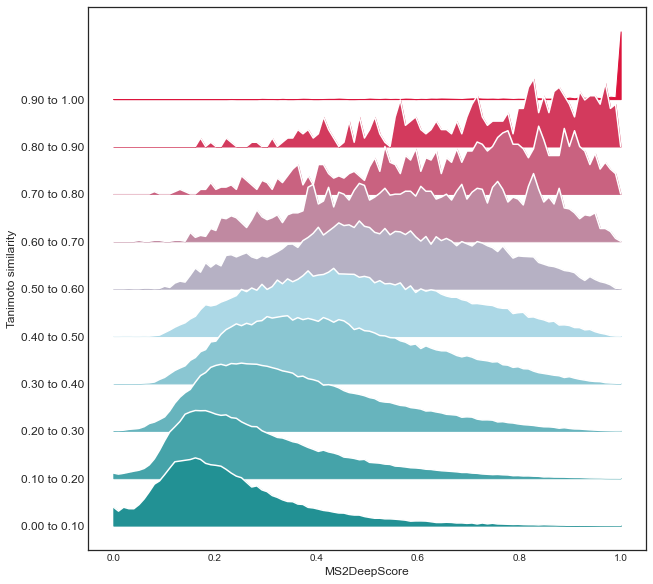

In [221]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

colors = ["crimson", "lightblue", "teal"]
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)


plt.figure(figsize=(10,10))
#fig, axes = plt.subplots(1, 1, sharex=True)
plt.style.use('seaborn-white')

shift = 0.7
alpha = 1.0 #0.5

tanimoto_bins = []
for i in range(n_bins):
    tanimoto_bins.append((i*d_bin, (i+1)*d_bin))
    
for i in range(0, len(histograms)):
    data = histograms[len(histograms)-i-1][0]
    data = data/max(data)
    plt.fill_between(histograms[0][1][:100], -shift*i, [(-shift*i + x) for x in data], color=cmap1(i/10), alpha=alpha)
    if i > 0:
        plt.plot(histograms[0][1][:100], [(-shift*i + x) for x in data], color="white")
    
plt.yticks(-shift*np.arange(len(histograms)),
           [f"{a:.2f} to {b:.2f}" for (a, b) in tanimoto_bins[::-1]], fontsize=12)
plt.xlabel("MS2DeepScore", fontsize=12)
plt.ylabel("Tanimoto similarity", fontsize=12)

## Try batchnorm etc. --> FAILED!

In [179]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Input, Flatten, Subtract, Lambda, Concatenate, \
    GaussianNoise, Dot, Dropout, BatchNormalization
from tensorflow.keras.models import Model

In [182]:
embedding_dim = 400
#dropout_rate = 0.1
#gaussian_noice = 0.025
print("Vector dimension:", vector_dim)

# Encoder network
input_data  = Input(shape = (1, vector_dim), name="encoder_input")
encoding = Dense(embedding_dim, activation = 'relu', #kernel_regularizer=tf.keras.regularizers.l1(0.0001),
                 name="dense_101")(input_data)
encoding = BatchNormalization()(encoding)
encoding = Dense(embedding_dim, activation = 'relu', name="dense_102")(encoding)
encoding = BatchNormalization()(encoding)
encoding = Dense(embedding_dim, activation = 'relu', name="dense_103")(encoding)
encoding = BatchNormalization()(encoding)
encoding = Dense(embedding_dim, activation = 'relu', name="dense_104")(encoding)

encoder = Model(input_data, encoding)

# Scoring network
spectrum1 = Input(shape = (1, vector_dim), name="scoring_input1")
spectrum2 = Input(shape = (1, vector_dim), name="scoring_input2")

embedding1 = encoder(spectrum1)
embedding2 = encoder(spectrum2)

cosine_similarity = Dot(axes=(2, 2), normalize=True, name="cosine_similarity")([embedding1, embedding2])

scoring_network = Model(inputs=[spectrum1, spectrum2], outputs = [cosine_similarity])

scoring_network.summary()
encoder.summary()

Vector dimension: 9998
Model: "functional_51"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
scoring_input1 (InputLayer)     [(None, 1, 9998)]    0                                            
__________________________________________________________________________________________________
scoring_input2 (InputLayer)     [(None, 1, 9998)]    0                                            
__________________________________________________________________________________________________
functional_49 (Functional)      (None, 1, 400)       4485600     scoring_input1[0][0]             
                                                                 scoring_input2[0][0]             
__________________________________________________________________________________________________
cosine_similarity (Dot)         (None, 1, 1)         0         

In [184]:
epochs = 70
learning_rate = 0.001
metrics = ["accuracy"]

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

# Parameters
patience_scoring_net = 8
scoring_network_output_file = "scoring_network_201028_AllInchikey_BatchNorm_cosine.hdf5"

scoring_network.compile(
    loss='mse',
    optimizer=Adam(learning_rate=learning_rate),
    metrics=metrics)

checkpointer = ModelCheckpoint(
    filepath = scoring_network_output_file,
    # monitor='val_accuracy',
    monitor='val_loss', mode="min",
    verbose=1,
    save_best_only=True
    )

earlystopper_scoring_net = EarlyStopping(
    # monitor='val_accuracy',
    monitor='val_loss', mode="min",
    patience=patience_scoring_net,
    verbose=1
    )

scoring_network.fit_generator(
    generator=train_generator,
    validation_data=val_generator,
    epochs = epochs,
    callbacks = [
        earlystopper_scoring_net,
        checkpointer,
        #TensorBoard(log_dir = os.path.join(ROOT, "tmp", "tensorboard", "{timestamp}"))
        ]
    )

Epoch 1/70
512/512 [==============================] - ETA: 0s - loss: 0.0488 - accuracy: 0.0423
Epoch 00001: val_loss improved from inf to 0.04181, saving model to scoring_network_201028_AllInchikey_BatchNorm_cosine.hdf5
512/512 [==============================] - 198s 387ms/step - loss: 0.0488 - accuracy: 0.0423 - val_loss: 0.0418 - val_accuracy: 0.0511
Epoch 2/70
512/512 [==============================] - ETA: 0s - loss: 0.0413 - accuracy: 0.0404
Epoch 00002: val_loss improved from 0.04181 to 0.03483, saving model to scoring_network_201028_AllInchikey_BatchNorm_cosine.hdf5
512/512 [==============================] - 206s 403ms/step - loss: 0.0413 - accuracy: 0.0404 - val_loss: 0.0348 - val_accuracy: 0.0549
Epoch 3/70
512/512 [==============================] - ETA: 0s - loss: 0.0384 - accuracy: 0.0438
Epoch 00003: val_loss improved from 0.03483 to 0.03445, saving model to scoring_network_201028_AllInchikey_BatchNorm_cosine.hdf5
512/512 [==============================] - 176s 344ms/step 

In [186]:
for layer in scoring_network.layers[2].layers:
    print(layer.name)

encoder_input
dense_101
batch_normalization_3
dense_102
batch_normalization_4
dense_103
batch_normalization_5
dense_104


In [188]:
embedding_dim = 400

# Encoder network
input_data  = Input(shape = (1, vector_dim), name="encoder_input")
encoding = Dense(embedding_dim, activation = 'relu', #kernel_regularizer=tf.keras.regularizers.l1(0.0001),
                 name="dense_101")(input_data)
encoding = Dense(embedding_dim, activation = 'relu', name="dense_102")(encoding)
encoding = Dense(embedding_dim, activation = 'relu', name="dense_103")(encoding)
encoding = Dense(embedding_dim, activation = 'relu', name="dense_104")(encoding)

encoder = Model(input_data, encoding)
for i, num in enumerate([0, 1, 3, 5, 7]):   
    encoder.layers[i].set_weights(scoring_network.layers[2].layers[num].get_weights())
encoder.summary()

Model: "functional_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 1, 9998)]         0         
_________________________________________________________________
dense_101 (Dense)            (None, 1, 400)            3999600   
_________________________________________________________________
dense_102 (Dense)            (None, 1, 400)            160400    
_________________________________________________________________
dense_103 (Dense)            (None, 1, 400)            160400    
_________________________________________________________________
dense_104 (Dense)            (None, 1, 400)            160400    
Total params: 4,480,800
Trainable params: 4,480,800
Non-trainable params: 0
_________________________________________________________________


In [189]:
from matchms.similarity.vector_similarity_functions import cosine_similarity_matrix, cosine_similarity

In [191]:
encoder.input_shape[2]


9998

In [195]:
embedding_dim

400

In [197]:
#def create_similarity_matrix(IDs, embedding_dim, encoder, inchikey_mapping, inchikey_list):
    
def get_embedding_array(IDs, embedding_dim, encoder, inchikey_mapping, inchikey_list):
    embeddings = np.zeros((len(IDs), embedding_dim))
    for i, ID in enumerate(IDs):
        X = np.zeros((1, encoder.input_shape[2]))
        inchikey = inchikey_mapping.loc[ID]["inchikey"]
        ID1_all = np.where(inchikey_list == inchikey)[0][0]
        idx = np.array([x for x in spectrums_binned_dicts[ID1_all].keys()])
        X[0, idx] = np.array([x for x in spectrums_binned_dicts[ID1_all].values()])
        embeddings[i, :] = encoder.predict(X)

    return embeddings

embeddings = get_embedding_array(testIDs, embedding_dim, encoder, metadata, inchikeys_array)

In [198]:
embeddings.shape

(1085, 400)

In [199]:
MS2DS_scores = cosine_similarity_matrix(embeddings, embeddings)

In [200]:
MS2DS_scores.shape

(1085, 1085)

In [209]:
np.min(MS2DS_scores[:100,:100]), np.min(scores_test_commutative[:100,:100])

(0.23096171269685614, 0.020642523)

In [204]:
scores_ref[:10,:5]

array([[1.        , 0.20546448, 0.21165644, 0.12724014, 0.13975155],
       [0.20546448, 1.        , 0.17910448, 0.32019704, 0.25761532],
       [0.21165644, 0.17910448, 1.        , 0.2177264 , 0.18679549],
       [0.12724014, 0.32019704, 0.2177264 , 1.        , 0.1972873 ],
       [0.13975155, 0.25761532, 0.18679549, 0.1972873 , 1.        ],
       [0.09266943, 0.21243942, 0.09681881, 0.12857143, 0.18410042],
       [0.12628488, 0.44745326, 0.11538462, 0.21634615, 0.24156188],
       [0.08962264, 0.14327485, 0.10714286, 0.14402619, 0.15850144],
       [0.08724832, 0.23859935, 0.09716599, 0.15818584, 0.19008264],
       [0.07430341, 0.17278798, 0.08566978, 0.12711864, 0.13846154]])

In [205]:
n_bins = 10
d_bin = 1/n_bins
hist_bins = np.linspace(0, 1, 100) 
hist_bins = np.concatenate((hist_bins, np.array([2.0])))

histograms = []
for i in range(n_bins):
    idx = np.where((scores_ref > i*d_bin) & (scores_ref <= (i + 1) * d_bin))
    a, b = np.histogram(MS2DS_scores[idx], bins=hist_bins)
    histograms.append((a, b))

Text(0, 0.5, 'Tanimoto similarity')

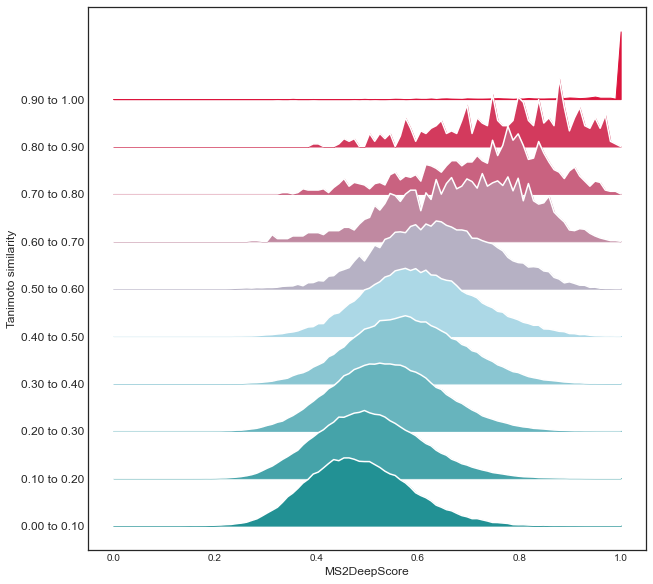

In [206]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

colors = ["crimson", "lightblue", "teal"]
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)


plt.figure(figsize=(10,10))
#fig, axes = plt.subplots(1, 1, sharex=True)
plt.style.use('seaborn-white')

shift = 0.7
alpha = 1.0 #0.5

tanimoto_bins = []
for i in range(n_bins):
    tanimoto_bins.append((i*d_bin, (i+1)*d_bin))
    
for i in range(0, len(histograms)):
    data = histograms[len(histograms)-i-1][0]
    data = data/max(data)
    plt.fill_between(histograms[0][1][:100], -shift*i, [(-shift*i + x) for x in data], color=cmap1(i/10), alpha=alpha)
    if i > 0:
        plt.plot(histograms[0][1][:100], [(-shift*i + x) for x in data], color="white")
    
plt.yticks(-shift*np.arange(len(histograms)),
           [f"{a:.2f} to {b:.2f}" for (a, b) in tanimoto_bins[::-1]], fontsize=12)
plt.xlabel("MS2DeepScore", fontsize=12)
plt.ylabel("Tanimoto similarity", fontsize=12)